In [1]:
#import dependencies 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
# INCLUDING 'inspect'
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
#reflect an existing database with a new model
base = automap_base()
#refelct the tables 
base.prepare (engine, reflect = True)

In [5]:
# view all the classes that the automap found
base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [7]:
#Create our session (link) from python to DB
session = Session(engine)

Exploratory Climate Analysis

In [9]:

#I.Design a query to retrieve the last 12 months of precipitation data and plot the results

#II.Calculate the date 1 year ago from today
#a: one_year_ago = [ last_date captured ] - [365 days/1 year]

#III.a: last_date calculation
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [10]:
#III.b: one_year_ago calculation
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [11]:
# IV: Perform a query to retrieve the data and precipitation scores
# a: Save the query results as a Pandas DataFrame and 
# b: set the index to the date column DATE = INDEX
# c: Sort/ORDER_BY the dataframe by date
# d: Query measurement for `Measurement.date`, `Measurement.prcp`,+
# e: save the query into results

prcp = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

# f: Load the results into a pandas dataframe. Set the index to the `date`
prcp_df = pd.DataFrame(prcp, columns=['date','prcp'])
prcp_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<Figure size 360x288 with 0 Axes>

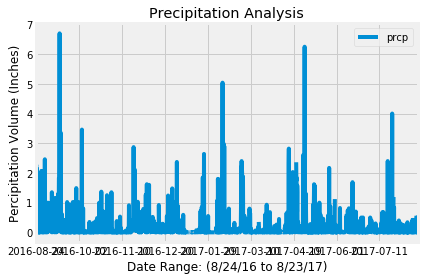

In [12]:
# g: Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
fig1 = plt.figure(figsize=(5,4))
prcp_df.plot('date', 'prcp')
plt.grid(True)
plt.xlabel("Date Range: (8/24/16 to 8/23/17)")
plt.ylabel("Percipitation Volume (Inches)")
plt.title("Precipitation Analysis")
plt.legend()
plt.tight_layout()
plt.show()
plt.close(fig1)

In [13]:
# Use Pandas to calcualte the summary statistics
# for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# How many stations are available in this dataset?
location_station = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations that are available.".format(location_station))

There are 9 stations that are available.


In [15]:
# What are the most active stations?

# weather_observations = highest tobs
weather_observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

popular_station = weather_observations[0][0]    
popular_station

'USC00519281'

In [16]:
# List the stations and the counts in descending order.
print("-----------------------------------------------------------------")
print("The most active station is",popular_station,"and contains",weather_observations[0][1],"weather observations.")
print("-----------------------------------------------------------------")
print("This is a list of the most active stations, displayed in descending order:")
for station, count in weather_observations:
    print("this station id:",station,"has this many weather observations:",count,)

-----------------------------------------------------------------
The most active station is USC00519281 and contains 2772 weather observations.
-----------------------------------------------------------------
This is a list of the most active stations, displayed in descending order:
this station id: USC00519281 has this many weather observations: 2772
this station id: USC00519397 has this many weather observations: 2724
this station id: USC00513117 has this many weather observations: 2709
this station id: USC00519523 has this many weather observations: 2669
this station id: USC00516128 has this many weather observations: 2612
this station id: USC00514830 has this many weather observations: 2202
this station id: USC00511918 has this many weather observations: 1979
this station id: USC00517948 has this many weather observations: 1372
this station id: USC00518838 has this many weather observations: 511


In [17]:
# Using the station id from the previous query, 
# calculate the 'lowest temperature' recorded, 
# 'highest temperature' recorded, and 'average temperature' most active station?
temperature_intel = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == popular_station).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

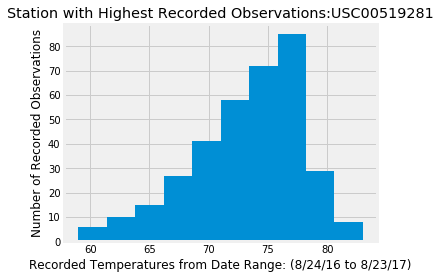

In [18]:

# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
# plot the results as a histogram
fig2 = plt.figure(figsize=(5,4))
plt.grid(True)
temp_intel_df = pd.DataFrame(temperature_intel)
plt.hist(temp_intel_df['tobs'])
bin_size = 12
plt.xlabel("Recorded Temperatures from Date Range: (8/24/16 to 8/23/17)")
plt.ylabel("Number of Recorded Observations")
plt.title("Station with Highest Recorded Observations:" + popular_station)
plt.show()

In [19]:
# Write a function called `calc_temps` 
# that will accept 'start_date' and 
# 'end_date' in the format '%Y-%m-%d' 
# and return the 'minimum', 'average', and 'maximum temperatures' 
# for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
def calc_temps2(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps2('2017-01-01', '2017-01-20'))

[(60.0, 69.49180327868852, 81.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your 'trip' using the 'previous year's' data for those same dates.
arrival_date = dt.date(2017, 1, 1)
departure_date = dt.date(2017, 1, 20)
one_year_ago = dt.timedelta(days=365)
tavg_year_ago = (calc_temps((arrival_date-one_year_ago), (departure_date-one_year_ago)))
print(tavg_year_ago)

[(61.0, 69.46610169491525, 78.0)]


In [22]:
# Define standard error (max minus min temps)
yerr_val = tavg_year_ago[0][2] - tavg_year_ago[0][0]

# Y value is the average temperature for the trip's date range; X is zero since we only need one bar
y = [tavg_year_ago[0][1]]
x = 0

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 360x288 with 0 Axes>

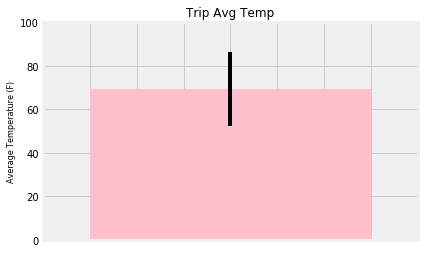

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Define plot
fig3 = plt.figure(figsize=(5,4))
fig, ax = plt.subplots()

# Add  labels, title and axes ticks
ax.set_ylabel("Average Temperature (F)", fontsize=8)
ax.set_title("Trip Avg Temp", fontsize=12)

# Set the limits of the x and y axes, no tick params
ax.bar(x, y, width=1.5, color="pink", yerr=yerr_val)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 100)
ax.set_xbound(lower=-1, upper=1)
ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 
plt.show()